In [1]:
import numpy as np
import twitter, re, datetime, pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier

___
# [1] Setup Twitter API

##### This will be done on the following steps
- 1. Setup API keys
- 2. Test function by using **@nytimes** account
- 3. Print results
- 4. Setup TweetMiner function
___

In [2]:
# Taken from Mike Taylor A Python wrapper around the Twitter API.
# https://github.com/bear/python-twitter

twitter_keys = {
    'consumer_key':        'L4sziHBqV4VUIfKezbos0JMVl',
    'consumer_secret':     'lJau6R7GIHFwoGR5wB3PlLQPXBChwzJFJ9WGXXtazcDSA1Vb1X',
    'access_token_key':    '941359629606539264-05XcmQfdwMXTbPNWS3r7cZThvbQBxCK',
    'access_token_secret': 'VdE3VJVk6oxbohQGcw7WYA5Tg4Sr8kW9duTO1wxmB6qXk'
}

api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret'],
    tweet_mode = 'extended'
)

# double check if the API is working

type(api)

twitter.api.Api

In [3]:
# There is a limit set on the count by Twitter API, can't exceed 200
# Link with the highlighted text
# https://tinyurl.com/y3cx3m6a

# A first test trial to check everything is working. We are using Joe Biden's Account
# https://twitter.com/JoeBiden

x = api.GetUserTimeline(screen_name="nytimes", count=5, include_rts=False)
x = [_.AsDict() for _ in x]

x[0]

{'created_at': 'Tue Dec 08 20:40:04 +0000 2020',
 'favorite_count': 7,
 'full_text': 'Scientists are tracking coronavirus outbreaks in New York by monitoring the smelly, gray sewage that flows through underground pipes in hopes of identifying clusters days before they appear through patient testing. https://t.co/fGOZRg7SS7',
 'hashtags': [],
 'id': 1336410237952274433,
 'id_str': '1336410237952274433',
 'lang': 'en',
 'retweet_count': 3,
 'source': '<a href="http://www.socialflow.com" rel="nofollow">SocialFlow</a>',
 'urls': [{'expanded_url': 'https://nyti.ms/2JLnBFD',
   'url': 'https://t.co/fGOZRg7SS7'}],
 'user': {'created_at': 'Fri Mar 02 20:41:42 +0000 2007',
  'description': 'News tips? Share them here: https://t.co/ghL9OoYKMM',
  'favourites_count': 18368,
  'followers_count': 48380272,
  'following': True,
  'friends_count': 902,
  'id': 807095,
  'id_str': '807095',
  'listed_count': 205583,
  'location': 'New York City',
  'name': 'The New York Times',
  'profile_background_c

In [4]:
# As you can see we get a list of information about each tweet
# We want to print the tweet text and tweet ID


for element in x:
    print(element['id'])
    print(element['full_text'])
    print('____________________________')

1336410237952274433
Scientists are tracking coronavirus outbreaks in New York by monitoring the smelly, gray sewage that flows through underground pipes in hopes of identifying clusters days before they appear through patient testing. https://t.co/fGOZRg7SS7
____________________________
1336408363954008068
Why can't social networks like Facebook and Twitter stop fake accounts?

The answer has to do with the enormity of the platforms, the complexity of catching fakes, and the business incentives of the companies that run the sites. https://t.co/t9WgHxCWu8
____________________________
1336405811149426688
Here’s a guide to some other commonly asked questions about Britain’s vaccine rollout. https://t.co/506p9H70sM
____________________________
1336405217072586758
Sen. Ron Johnson has suggested that the dangers of the coronavirus have been overblown and excessively regulated. Now the Wisconsin Republican is using his Senate panel to amplify dubious theories and questionable treatments pushe

In [5]:
# We could call the Tweet ID

print(type(x[0]))
x[0]['id']

<class 'dict'>


1336410237952274433

#### TweetMiner

In [6]:
#TweetMiner function from Bhishan Poudel and Mike Roman

class TweetMiner(object):

    
    def __init__(self, api, result_limit = 200):
        
        self.api = api        
        self.result_limit = result_limit
        

    def mine_user_tweets(self, user="nytimes", mine_retweets=False, max_pages=20):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id - 1, include_rts=mine_retweets)
                statuses = [ _.AsDict() for _ in statuses]
            else:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, include_rts=mine_retweets)
                statuses = [_.AsDict() for _ in statuses]
                
            for item in statuses:
                # Using try except here.
                # When retweets = 0 we get an error (GetUserTimeline fails to create a key, 'retweet_count')
                try:
                    mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   item['retweet_count'],
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                except:
                        mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   0,
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                last_tweet_id = item['id']
                data.append(mined)
                
            page += 1
            
        return data

# [2] Establishing Class
### ---------------------------
##### This will be done on the following steps
- 1. Setup result limit (200) on TweetMiner
- 2. Mine 4 __Far left__ Media accounts **[@NewYorker ; @voxdotcom ; @nytopinion ; @Newsweek]** tweets
- 3. Mine 4 __Far Right__ Media accounts **[@DailyMail ; @FoxNewsOpinion ; @NYPostOpinion ; @NRO]** tweets
- 4. Print results
- 5. Convert output tweets to a pandas dataframe into two group (**Far Left** and **Far Right**)

In [7]:
# Creating a limit of 200 - Complying with rate limit request

miner = TweetMiner(api, result_limit=200)

In [8]:
# Creating the two classes

# Far-Left

newyorker = miner.mine_user_tweets(user="NewYorker")
vox = miner.mine_user_tweets(user="voxdotcom")
nytimes = miner.mine_user_tweets(user="nytopinion")
newsweek = miner.mine_user_tweets(user="Newsweek")

# Far-Right

dailymail = miner.mine_user_tweets(user="DailyMail")
foxnews = miner.mine_user_tweets(user="FoxNewsOpinion")
nypost = miner.mine_user_tweets(user="NYPostOpinion")
nationalreview = miner.mine_user_tweets(user="NRO")

In [9]:
# Printing the first tweet to see our results

left=[newyorker,vox,nytimes,newsweek]

for x in left:

    print(x[1]['text'])
    print('---')

“America’s gaping, cosmic black hole and here they come with another Band-Aid to patch it.” Read a new short story by John Edgar Wideman. https://t.co/MnSlhbquB5
---
The UK granted temporary emergency use authorization for the Pfizer and BioNTech vaccine last week.

The country purchased 40 million doses of this version of the two-dose vaccine, which will go toward inoculating 20 million people through 2021.
https://t.co/WZKHNUopoL
---
For judges and their families, better security is a matter of life and death, writes Judge Esther Salas, whose only son was murdered in July by an anti-feminist lawyer who had come to her home armed with a gun https://t.co/815lRunp37
---
10M in U.S. could get COVID in 6 months after vaccine introduction with current infection rates https://t.co/lMBTXrV4wz
---


In [10]:
# Printing the first tweet to see our results

right=[dailymail,foxnews,nypost,nationalreview]

for x in right:

    print(x[1]['text'])
    print('---')

Trump claims 'the next administration will be the Trump administration' if legislators or the Supreme Court have 'the courage' to overthrow election https://t.co/CH9s6iJiZc
---
Ex-FBI Agent: President Trump, don’t say ‘You’re Fired!’ to Mueller https://t.co/F3D9gSFnap
---
Avoiding vaccine puts everyone else at risk — double for first responders https://t.co/GEN8xNBaH7 https://t.co/quNqYLbtmn
---
The Tsunami of Virtue-Signaling in Financial Services | https://t.co/yrud42zHoE via Eric Grover https://t.co/MqJTDgxIUL
---


___
___

#### Creating dataframe

In [11]:
# Taking the tweets output from tweetminer and converting it into a pandas dataframe
# A: Left

ny = pd.DataFrame(newyorker)
vx = pd.DataFrame(vox)
nt = pd.DataFrame(nytimes)
nw = pd.DataFrame(newsweek)

# Replacing the 4 twitter accounts name with Far Left

listl=['NewYorker','Newsweek','nytopinion','voxdotcom']

# Merging the 4 users into one dataframe and naming Far Left 

far_left = pd.concat([ny, vx, nt, nw], axis=0).reset_index(drop=True)
far_left['handle'].replace(listl,["Far Left","Far Left","Far Left","Far Left"], inplace=True)

print(far_left.shape)
far_left.head(5)

(11985, 6)


,tweet_id,handle,retweet_count,text,mined_at,created_at
0,1336404390471733249,Far Left,4,“A Teacher” is a promising but emotionally vac...,2020-12-08 15:40:20.372345,Tue Dec 08 20:16:50 +0000 2020
1,1336395346801516545,Far Left,7,"“America’s gaping, cosmic black hole and here ...",2020-12-08 15:40:20.372345,Tue Dec 08 19:40:54 +0000 2020
2,1336383280090902531,Far Left,9,From Bad Bunny's “YHLQMDLG” to Soccer Mommy's ...,2020-12-08 15:40:20.372345,Tue Dec 08 18:52:57 +0000 2020
3,1336377613674291204,Far Left,192,What will tomorrow bring? https://t.co/2EE4d0FrJf,2020-12-08 15:40:20.372345,Tue Dec 08 18:30:26 +0000 2020
4,1336373176243253253,Far Left,13,The first time Dr. Valery Shikankov went to th...,2020-12-08 15:40:20.372345,Tue Dec 08 18:12:48 +0000 2020


In [12]:
# Taking the tweets output from tweetminer and converting it into a pandas dataframe
# B: Right

dm=pd.DataFrame(dailymail)
fn=pd.DataFrame(foxnews)
np=pd.DataFrame(nypost)
nr=pd.DataFrame(nationalreview)

# Replacing the 4 twitter accounts name with Far Right

listr=['DailyMail','FoxNewsOpinion','NRO','NYPostOpinion']

# Merging the 4 users into one dataframe and naming Far Right

far_right = pd.concat([dm, fn, np, nr], axis=0).reset_index(drop=True)
far_right['handle'].replace(listr,["Far Right","Far Right","Far Right","Far Right"], inplace=True)

print(far_right.shape)
far_right.head(5)

(11383, 6)


,tweet_id,handle,retweet_count,text,mined_at,created_at
0,1336409224675520513,Far Right,3,EXCLUSIVE: Dad accused of beheading his two ch...,2020-12-08 15:40:46.281245,Tue Dec 08 20:36:03 +0000 2020
1,1336407514200612875,Far Right,5,Trump claims 'the next administration will be ...,2020-12-08 15:40:46.281245,Tue Dec 08 20:29:15 +0000 2020
2,1336406713688317954,Far Right,4,'Delta Dawn' toddler found dead in a Mississip...,2020-12-08 15:40:46.281245,Tue Dec 08 20:26:04 +0000 2020
3,1336404183491244034,Far Right,0,Special-education teacher is robbed at knifepo...,2020-12-08 15:40:46.281245,Tue Dec 08 20:16:01 +0000 2020
4,1336401977174061061,Far Right,10,Texas AG files legal bid to overturn Biden's v...,2020-12-08 15:40:46.281245,Tue Dec 08 20:07:15 +0000 2020


#### Merging DataFrame

In [13]:
# Far right + Far left dataframe
# We're calling the data "tweets"

tweets = pd.concat([far_right, far_left], axis=0).reset_index(drop=True)

print(tweets.shape)
tweets.head(5)

(23368, 6)


,tweet_id,handle,retweet_count,text,mined_at,created_at
0,1336409224675520513,Far Right,3,EXCLUSIVE: Dad accused of beheading his two ch...,2020-12-08 15:40:46.281245,Tue Dec 08 20:36:03 +0000 2020
1,1336407514200612875,Far Right,5,Trump claims 'the next administration will be ...,2020-12-08 15:40:46.281245,Tue Dec 08 20:29:15 +0000 2020
2,1336406713688317954,Far Right,4,'Delta Dawn' toddler found dead in a Mississip...,2020-12-08 15:40:46.281245,Tue Dec 08 20:26:04 +0000 2020
3,1336404183491244034,Far Right,0,Special-education teacher is robbed at knifepo...,2020-12-08 15:40:46.281245,Tue Dec 08 20:16:01 +0000 2020
4,1336401977174061061,Far Right,10,Texas AG files legal bid to overturn Biden's v...,2020-12-08 15:40:46.281245,Tue Dec 08 20:07:15 +0000 2020


In [14]:
class color:
   
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

___
# [3] Using _Textacy_ to pre-process tweets

##### This will be done on the following steps 
- 1. Extract Tweets column as a text list
- 2. Use **Textacy** to pre-process tweets
```
____

In [15]:
from textacy import preprocessing as tp
from textacy import vsm
import textacy as textacy

In [16]:
# More information about textacy
# https://github.com/chartbeat-labs/textacy

# Text Pre-processing commands and documentation
# https://textacy.readthedocs.io/en/stable/api_reference/text_processing.html

In [17]:
# Use textacy to Pre-process text with following functions

# 1. Replace all Urls
# 2. Remove all accents
# 3. Replace Emojis
# 4. Replace Currency symbols
# 5. Replace hashtags
# 6. Replace Phone numbers
# 7. Remove punctuations "!@-—=+#$%’^&*)(/\;:.,~`"
# 8. Normalize unicode characters in text into canonical forms.

# We want to make sure we pass arguments to maintain API and Dict
# Converting tweet column from dataframe into a list

tweet_text=tweets['text'].values.tolist()

# Pre-process

clean_text=[tp.normalize.normalize_unicode(tp.remove.remove_punctuation(tp.replace.replace_phone_numbers
                              (tp.replace.replace_hashtags
                               (tp.replace_currency_symbols
                                (tp.replace.replace_emojis
                                 (tp.remove.remove_accents
                                  (tp.replace.replace_urls(x)))))), marks='?!@-—=+#$%’^&*)(/\;:.,~`'))for x in tweet_text]

In [18]:
# Original Text

print(tweet_text[4])
type(tweet_text)

Texas AG files legal bid to overturn Biden's victory by asking Supreme Court to rule out millions of mail-in ballots in other states https://t.co/21355dfMz8 https://t.co/fmU1spX4AR


list

In [19]:
# Checking if it's a list
# Cleaned Text

print(clean_text[4])
type(clean_text)

Texas AG files legal bid to overturn Biden's victory by asking Supreme Court to rule out millions of mail in ballots in other states _URL_ _URL_


list

___
# [4] Building Model

##### This will be done on the following steps
- 1. Create a target
- 2. TF IDF Vectorizer to vectorize text
- 3. Split training and test data
- 4. TF IDF Vectorizer to vectorize text
- 5. Grid search paramaters
```
____

In [20]:
# creating target

y = tweets['handle'].map(lambda x: 1 if x == 'Far Right' else 0).values
print(max(pd.Series(y).value_counts(normalize=True)))

0.5128808627182472


In [21]:
from sklearn.preprocessing import LabelEncoder

# Using label Encoder for the target

le = LabelEncoder()
y2=le.fit_transform(tweets['handle'].values)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter


# TF IDF Vectorizer to vectorize text

tfv = TfidfVectorizer(ngram_range=(2,4), max_features=23299)
cvec = CountVectorizer(ngram_range=(2,4), max_features=23299)
X = tfv.fit_transform(clean_text).todense()
X2= cvec.fit_transform(clean_text)

print (X2.shape)

(23368, 23299)


In [24]:
print (y2.shape)

(23368,)


#### Split data to train and test

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.35,random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15189, 23299), (15189,), (8179, 23299), (8179,))

#### Hyperparameter

In [26]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
params = {'penalty': ['l2']}

# Grid searching

gs = GridSearchCV(lr, param_grid=params, cv=5, verbose=0,n_jobs=1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=1,
             param_grid={'penalty': ['l2']})

In [27]:
print (gs.best_params_)
print (gs.best_score_)

{'penalty': 'l2'}
0.8476524878701414


In [28]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(LogisticRegression(), X_train, y_train, cv=3)

print (accuracies.mean())
print (1-y_train.mean())

0.8412667061689381
0.513529527947857


#### Model Score

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      4185
           1       0.93      0.74      0.83      3994

    accuracy                           0.85      8179
   macro avg       0.86      0.84      0.84      8179
weighted avg       0.86      0.85      0.85      8179

[[3955  230]
 [1021 2973]]


<AxesSubplot:>

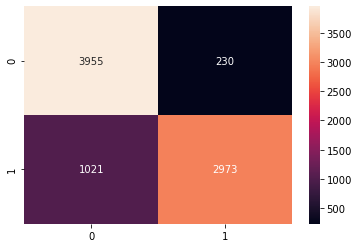

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

lr = LogisticRegression(penalty='l2',C=1)

lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

#lr_mod=lr.fit(X, y2)

print(classification_report(y_test, pred_lr))
print(confusion_matrix(y_test, pred_lr))
lr_cm=confusion_matrix(y_test, pred_lr)
sns.heatmap(lr_cm, annot=True, fmt="d")

___
# [5] Using outside training Media account to test module

##### This will be done on the following steps 
- 1. Use an outside **Far Left** and **Far Right** media twitter account to test prediction module
- 2. Huff Post **Far Left**
- 3. The American Spectator **Far Right**
- 4. Create a Prediction function to predict biasness of tweet
___

#### [1] Huff Post

In [30]:
# Using Huff post to test prediction
# Far Left
# https://twitter.com/HuffPost

huffpost = miner.mine_user_tweets(user="HuffPost")
hp = pd.DataFrame(huffpost)
hp.head(2)

,tweet_id,handle,retweet_count,text,mined_at,created_at
0,1336411427800834058,HuffPost,2,The Queen of Pop's new ink is very much a fami...,2020-12-08 15:50:43.841933,Tue Dec 08 20:44:48 +0000 2020
1,1336410470987657216,HuffPost,21,Late night hosts aren’t at all surprised that ...,2020-12-08 15:50:43.841933,Tue Dec 08 20:41:00 +0000 2020


              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2999
           1       0.00      0.00      0.00         0

    accuracy                           0.92      2999
   macro avg       0.50      0.46      0.48      2999
weighted avg       1.00      0.92      0.96      2999

[[2750  249]
 [   0    0]]


<AxesSubplot:>

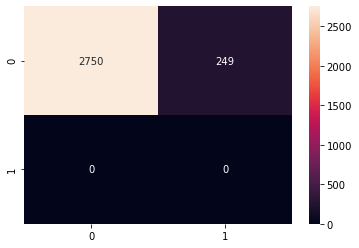

In [31]:
# Mining tweet

tweet_hp=hp['text'].values.tolist()

# Pre-process

clean_hp=[tp.normalize.normalize_unicode(tp.remove.remove_punctuation(tp.replace.replace_phone_numbers
                              (tp.replace.replace_hashtags
                               (tp.replace_currency_symbols
                                (tp.replace.replace_emojis
                                 (tp.remove.remove_accents
                                  (tp.replace.replace_urls(x)))))), marks='?!@-—=+#$%’^&*)(/\;:.,~`'))for x in tweet_hp]

# TF IDF Vectorizer

X3 = tfv.fit_transform(clean_hp).todense()
y3=le.fit_transform(hp['handle'].values)

# Fitting Module and printing confusion matrix

lr.fit(X, y2)
pred_lr = lr.predict(X3)

print(classification_report(y3, pred_lr))
print(confusion_matrix(y3, pred_lr))
lr_cm=confusion_matrix(y3, pred_lr)
sns.heatmap(lr_cm, annot=True, fmt="d")

#### **[2] The American Spectator**

In [32]:
# Using The American Spectator to test prediction
# Far Right
# https://twitter.com/amspectator

amspectator = miner.mine_user_tweets(user="amspectator")
ams = pd.DataFrame(amspectator)
ams.head(2)

,tweet_id,handle,retweet_count,text,mined_at,created_at
0,1336393370525196291,amspectator,3,RIP Chuck Yeager by Larry Thornberry \n\nhttps...,2020-12-08 15:51:03.159693,Tue Dec 08 19:33:03 +0000 2020
1,1336355330993885190,amspectator,1,Can Commercial Partnerships Save NASA From Bid...,2020-12-08 15:51:03.159693,Tue Dec 08 17:01:53 +0000 2020


              precision    recall  f1-score   support

           0       1.00      0.93      0.97      2966
           1       0.00      0.00      0.00         0

    accuracy                           0.93      2966
   macro avg       0.50      0.47      0.48      2966
weighted avg       1.00      0.93      0.97      2966

[[2767  199]
 [   0    0]]


<AxesSubplot:>

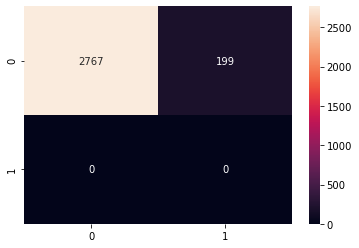

In [33]:
# Mining tweet

tweet_ams=ams['text'].values.tolist()

# Pre-process

clean_ams=[tp.normalize.normalize_unicode(tp.remove.remove_punctuation(tp.replace.replace_phone_numbers
                              (tp.replace.replace_hashtags
                               (tp.replace_currency_symbols
                                (tp.replace.replace_emojis
                                 (tp.remove.remove_accents
                                  (tp.replace.replace_urls(x)))))), marks='?!@-—=+#$%’^&*)(/\;:.,~`'))for x in tweet_ams]

# TF IDF Vectorizer

X4 = tfv.fit_transform(clean_ams).todense()
y4=le.fit_transform(ams['handle'].values)

# Fitting Module and printing confusion matrix

lr.fit(X, y2)
pred_lr = lr.predict(X4)


print(classification_report(y4, pred_lr))
print(confusion_matrix(y4, pred_lr))
lr_cm=confusion_matrix(y4, pred_lr)
sns.heatmap(lr_cm, annot=True, fmt="d")

#### **Create Prediction Function**

In [34]:
# Fitting into LR

estimator = LogisticRegression(penalty='l2',C=1)
estimator.fit(X,y)

# Testing TfIdf vectors with copied tweets
# First is from Biden

source_test = [
    "NFL sexual harassment investigation finds Washington Football Team paid out a confidential settlement in 2009",
]


# Printing results

Xtest = tfv.transform(source_test)
ac=pd.DataFrame(estimator.predict_proba(Xtest), columns=["Proba_Left", "Proba_Right"])
ac

,Proba_Left,Proba_Right
0,0.573585,0.426415


In [35]:
estimator.predict_proba(X)

array([[0.50731668, 0.49268332],
       [0.80904612, 0.19095388],
       [0.38904739, 0.61095261],
       ...,
       [0.73975502, 0.26024498],
       [0.83732348, 0.16267652],
       [0.71868203, 0.28131797]])

#### Prediction Function

In [36]:
# Creating a prediction function
# You could a paste a text from a tweet by either candidates and the module will predict to whom it belongs

def predict_text() :
    
    print(color.BOLD +'"PASTE TWEET TEXT HERE"'+ color.END)
    in_no = [input()]
    
    
    # Text Preprocess
    
    cleaning=[tp.normalize.normalize_unicode(tp.remove.remove_punctuation(tp.replace.replace_phone_numbers
                              (tp.replace.replace_hashtags
                               (tp.replace_currency_symbols
                                (tp.replace.replace_emojis
                                 (tp.remove.remove_accents
                                  (tp.replace.replace_urls(x)))))), marks='?!@,-—=+#$%’^&*)(/\;:.,~`'))for x in in_no]
    # TF IDF Vectorizer
    
    Xtest1 = tfv.transform(cleaning)
    pr=pd.DataFrame(estimator.predict_proba(Xtest1), columns=["Proba_Left", "Proba_Right"])
    
    # Plotting a bar chart
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,0.5,0.5])
    cand = ['Proba_Left', 'Proba_Right']
    probabilty = [float(pr['Proba_Left']*100),float(pr['Proba_Right']*100)]
    ax.bar(cand,probabilty)
    plt.show()
    
    # Print Answer
    
    if min(pr) == 'Proba_Left' :
        print(color.BOLD + color.BLUE +"THIS TWEET IS PROBABLY **FAR LEFT**"+ color.END)
    else:
        print (color.BOLD + color.RED +"THIS TWEET IS PROBABLY BY **FAR RIGHT**"+ color.END)


"PASTE TWEET TEXT HERE"


 Join me for a conversation with the next U.S. Senators from Georgia,  @ReverendWarnock  and  @Ossoff , along with  @StaceyAbrams  and  @NikemaWilliams . The stakes couldn’t be higher for their runoffs: 


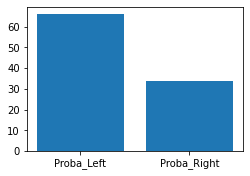

THIS TWEET IS PROBABLY **FAR LEFT**


In [37]:
predict_text()

In [38]:
# Text used is from @BarackObama Tweet
# https://twitter.com/BarackObama/status/1334614943379968003